# Classical DFT

In [9]:
import numpy as np

In [ ]:
def LennardJones(eps, sigma, r):
# Lennard-Jones potential function generator    
    return 4 * eps * ((sigma / r) ** 12 - (sigma / r) ** 6)


def MF_LennardJones(eps, sigma, z, T=300):
    # Mean-field contribution to the free energy with lennard-jones potential
    kB = 1.0  # Boltzmann constant, set to 1 for simplicity
    beta = 1/(kB*T)  # Inverse temperature (1/kT)
    
    phi = np.zeros_like(z)
    mask = abs(z) <= sigma
    phi[mask] = - 6 *np.pi *beta * eps* sigma**2 *(1/5)
    phi[~mask] = - 4 *np.pi *beta * eps* sigma**2 * (1/5 *(sigma/z[~mask])**10 - (1/2)*(sigma/z[~mask])**4)
    return phi  
    
def w(z, eps_w, sigma_w):
    return (2 * np.pi * eps_w ) * ((2/45) * (sigma_w / z)**9 - (1/3)* (sigma_w / z)**3)

def V_ex(z, h, eps_w, sigma_w):
    # External potential due to the walls
    return w(z, eps_w, sigma_w) + w(h - z, eps_w, sigma_w)

def chem_potential(nb, eps, sigma, beta):
    return beta * np.log((1 - nb * sigma**3)/nb) + (beta * 1 )/ (1 - nb * sigma**3) - (32/9) * np.pi * eps * sigma**3 * nb
                                   
def denisty_profile(nz, h, z, Phi, eps, sigma, eps_w, sigma_w, T=300):
    kB = 1.0  # Boltzmann constant, set to 1 for simplicity
    beta = 1/(kB*T)  # Inverse temperature (1/kT)
    return (1 - nz* sigma**3) *np.exp(beta* Phi) * np.exp(nz * sigma**3/(1 - nz* sigma**3)) * np.exp(- beta * np.trapz(nz * MF_LennardJones(eps, sigma, z),z)) * np.exp(- beta * (V_ex(z, h, eps_w, sigma_w))) 
                           
def convergence(nz_new, nz_old, tol= 1e-6):
    diff = np.sum(np.abs((nz_new - nz_old)/(nz_old)))
    return diff < tol

In [276]:
def solve_cDFT(n, eps, sigma, eps_w, sigma_w, n_b, h, T=1.2,
               Nz=500, max_iter=1000, tol=1e-6, alpha=0.02):
    z = np.linspace(9.5, h-0.5, Nz)
    #beta=1
    #n = n_b * np.exp(-beta * V_ex(z, h, eps_w, sigma_w))  # Initial guess adjusted for external potential
    #dz = z[1] - z[0]
    
    Phi = np.zeros_like(n)
    #n_b = n_b* np.ones(Nz)
    beta = 1/(1.0*T)
    #phi_bulk = np.trapz(n_b * MF_LennardJones(eps, sigma, z), z, h)
    Phi = chem_potential(n_b, eps, sigma, beta) #+ phi_bulk
    for iteration in range(max_iter):    
        n_new = denisty_profile(n, h, z, Phi, eps, sigma, eps_w, sigma_w, T)
        print(f"Iteration {iteration}: max density = {np.max(n_new)}, min density = {np.min(n_new)}")
        n_new = alpha * n_new + (1 - alpha) * n  # Mixing for stability
        
        if convergence(n_new, n, tol):
            print(f"Converged in {iteration} iterations.")
            return n_new
        n = n_new
    print("Maximum iterations reached without convergence.")
    return n_new


eps = 2.50
sigma = 1.0
eps_w = 3.0
sigma_w =2.0
n_b = 0.035
h = 10.0
T = 300.0
Nz = 500
beta = 1/(1.0*T)
z = np.linspace(0.5, h-0.5, Nz)
n =  n = n_b * np.exp(- beta * V_ex(z, h, eps_w, sigma_w)) # Initial guess adjusted for external potential

n =solve_cDFT(n, eps, sigma, eps_w, sigma_w, n_b, h, T, Nz)
    

Iteration 0: max density = 0.9974659989824607, min density = 0.9967955644773626
Iteration 1: max density = 0.9984239114327841, min density = 0.9969990546923417
Iteration 2: max density = 0.9998137737333854, min density = 0.9976154075445048
Iteration 3: max density = 1.0016484956008125, min density = 0.9986545332514712
Iteration 4: max density = 1.0039429321611009, min density = 1.0001279238442664
Iteration 5: max density = 1.0067141337450756, min density = 1.0020488414597455
Iteration 6: max density = 1.0099816395151109, min density = 1.0044325381266928
Iteration 7: max density = 1.0137678241071355, min density = 1.007296513276558
Iteration 8: max density = 1.0180983087670104, min density = 1.010660816680376
Iteration 9: max density = 1.0230024514260445, min density = 1.0145484063887915
Iteration 10: max density = 1.0285139340223215, min density = 1.018985573660619
Iteration 11: max density = 1.034671470445587, min density = 1.0240024499817837
Iteration 12: max density = 1.041519665201

/var/folders/xh/wxdw6l9x38q9r35yjqjckyn40000gn/T/ipykernel_53951/1338572193.py:34: RuntimeWarning: overflow encountered in divide
  diff = np.sum(np.abs((nz_new - nz_old)/(nz_old)))
/var/folders/xh/wxdw6l9x38q9r35yjqjckyn40000gn/T/ipykernel_53951/1338572193.py:31: RuntimeWarning: overflow encountered in exp
  return (1 - nz* sigma**3) *np.exp(beta* Phi) * np.exp(nz * sigma**3/(1 - nz* sigma**3)) #* np.exp(- beta * np.trapz(nz * MF_LennardJones(eps, sigma, z),z)) * np.exp(- beta * (V_ex(z, h, eps_w, sigma_w)))
/var/folders/xh/wxdw6l9x38q9r35yjqjckyn40000gn/T/ipykernel_53951/1338572193.py:31: RuntimeWarning: invalid value encountered in divide
  return (1 - nz* sigma**3) *np.exp(beta* Phi) * np.exp(nz * sigma**3/(1 - nz* sigma**3)) #* np.exp(- beta * np.trapz(nz * MF_LennardJones(eps, sigma, z),z)) * np.exp(- beta * (V_ex(z, h, eps_w, sigma_w)))


In [274]:
z = np.linspace(0.5, h-0.5, Nz)
beta = 1/(1.0*T)
# Initial guess
n = n_b * np.exp(- beta * V_ex(z, h, eps_w, sigma_w)) # Initial guess adjusted for external potential
n_new = denisty_profile(n, h, z, 1300, eps, sigma, eps_w, sigma_w, T)
dz = z[1] - z[0]
V_ex(z, h, eps_w, sigma_w)

array([ 2.19211061e+05,  1.59280884e+05,  1.16995638e+05,  8.68083198e+04,
        6.50203246e+04,  4.91325423e+04,  3.74352238e+04,  2.87449320e+04,
        2.22334955e+04,  1.73153429e+04,  1.35723838e+04,  1.07033462e+04,
        8.48923730e+03,  6.76955248e+03,  5.42572925e+03,  4.36953261e+03,
        3.53483071e+03,  2.87172240e+03,  2.34231072e+03,  1.91763790e+03,
        1.57544662e+03,  1.29853331e+03,  1.07352910e+03,  8.89991473e+02,
        7.39723378e+02,  6.16259895e+02,  5.14479003e+02,  4.30304892e+02,
        3.60480645e+02,  3.02393194e+02,  2.53937892e+02,  2.13413246e+02,
        1.79438739e+02,  1.50890389e+02,  1.26850020e+02,  1.06565156e+02,
        8.94172060e+01,  7.48961107e+01,  6.25800884e+01,  5.21193818e+01,
        4.32231774e+01,  3.56490442e+01,  2.91943769e+01,  2.36894444e+01,
        1.89917236e+01,  1.49812685e+01,  1.15569150e+01,  8.63316090e+00,
        6.13759611e+00,  4.00877860e+00,  2.19447582e+00,  6.50204609e-01,
       -6.61983892e-01, -

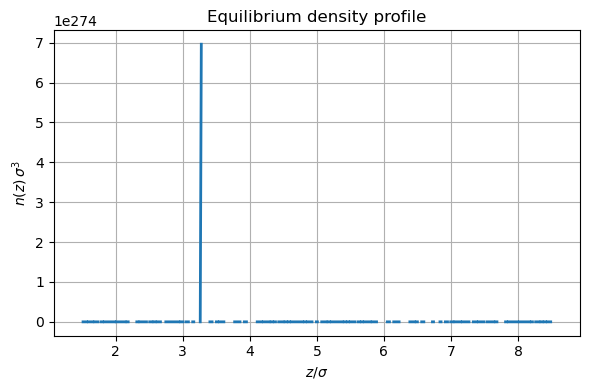

In [269]:
import matplotlib.pyplot as plt
z = np.linspace(1, h-1, Nz)
plt.figure(figsize=(6, 4))
plt.plot(z, n, lw=2)
plt.xlabel(r"$z / \sigma$")
plt.ylabel(r"$n(z)\,\sigma^3$")
plt.title("Equilibrium density profile")
plt.grid(True)
plt.tight_layout()
plt.show()

In [135]:
Phi = chem_potential(n_b, eps, sigma, T)
z = np.linspace(1, h-1, 10)
kb = 1 #1.380649e-23  # Boltzmann constant in J/K
print(np.exp(- 1 * V_ex(z, h, eps_w, sigma_w)))
n = n_b * np.ones_like(z)* np.exp(- 1 * V_ex(z, h, eps_w, sigma_w))
print(n)
denisty_profile(n, h, z, Phi, eps, sigma, eps_w, sigma_w, T=300)

[10.13658958  1.49146545  1.14058027  1.06676148  1.04577281  1.04577281
  1.06676148  1.14058027  1.49146545 10.13658958]
[0.35478064 0.05220129 0.03992031 0.03733665 0.03660205 0.03660205
 0.03733665 0.03992031 0.05220129 0.35478064]


array([0.00017436, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00017436])

In [34]:
import numpy as np


def solve_cDFT(epsilon, sigma, n_b, h, T,
               Nz=400, max_iter=5000, tol=1e-6, mixing=0.05):
    """
    Solve Euler–Lagrange equation via Picard iterations.
    """

    kB = 1.0
    beta = 1/(kB*T)

    # spatial grid
    z = np.linspace(0.5*h/Nz, h-0.5*h/Nz, Nz)
    dz = z[1] - z[0]

    # initial guess
    n = n_b * np.ones(Nz)

    # chemical potential (mean-field bulk)
    phi_bulk = np.trapz(n_b * MF_LennardJones( epsilon, sigma, z - z[Nz//2]), z)
    mu = chem_potential(n_b, epsilon_w, sigma_w, T) + phi_bulk
    print("Chemical potential:", mu)
    # external potential
    Vex = V_ex(z, h, epsilon_w, sigma_w)

    for it in range(max_iter):
        # convolution integral
        Phi = np.zeros_like(n)
        for i in range(Nz):
            Phi[i] = np.sum(n * MF_LennardJones( epsilon, sigma, z[i]-z)) * dz

        # Picard update
        arg = -beta * (Phi + Vex - mu)
        n_new = np.exp(arg) / (1 + sigma**3 * np.exp(arg))

        # mixing for stability
        n_new = (1-mixing)*n + mixing*n_new

        err = np.max(np.abs(n_new - n))
        n = n_new

        if convergence(n_new, n, tol):
            print(f"Converged in {it} iterations")
            break
    else:
        print("Warning: did not converge")

    return z, n


# -------------------------------
# Example usage
# -------------------------------
if __name__ == "__main__":
    epsilon = 1.0
    sigma = 1.0
    epsilon_w = 1.0
    sigma_w = 1.0
    n_b = 0.1
    h = 10.0
    T = 300.0

    z, n = solve_cDFT(epsilon, sigma, epsilon_w, sigma_w, n_b, h, T)

    # simple diagnostic
    print("Mean density:", np.trapz(n, z)/h)


TypeError: 'float' object cannot be interpreted as an integer

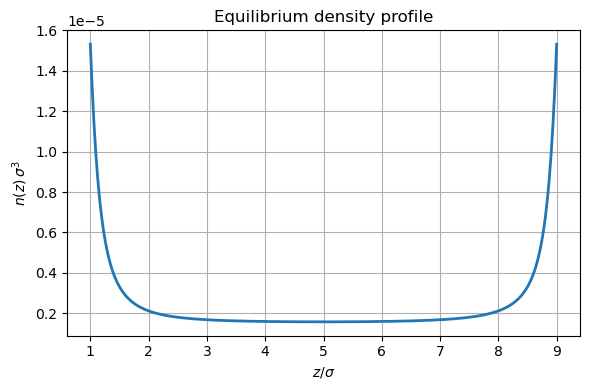

In [ ]:
def dOmega(nz, h, z, V_ex, eps, sigma, eps_w, sigma_w, beta):

    return 1/beta * np.log(nz/(1 - nz* sigma**3)) + 1/beta * nz * sigma**3/(1 - nz* sigma**3) + np.trapz(nz*MF_LennardJones(eps, sigma,z), z, h) + V_ex(z, h, eps_w, sigma_w)
    
epsilon = 1.0
sigma = 1.0
epsilon_w = 1.0
sigma_w = 1.0
n_b = 0.8
h = 10.0
T = 300.0
Nz = 500
n = n_b * np.ones(Nz)


z = np.linspace(0.5*h/Nz, h-0.5*h/Nz, Nz)
Phi = dOmega(n, h, z, V_ex, epsilon, sigma, epsilon_w, sigma_w, 1/(1.0*T))

n_new = denisty_profile(n, h, z, Phi, epsilon, sigma, epsilon_w, sigma_w, T)


print(n_new)